In [ ]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

In [ ]:
source_path = '../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [7]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [8]:
chan_data = []
for contact in range(7):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 50, 3000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH1.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH2.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH3.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH4.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH5.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH6.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH7.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH8.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-10_14-02-35/101_CH9.continuous...
Loading continuous data...
Read

In [9]:
common_avg_ref(chan_data)
chan_data = scipy.signal.detrend(chan_data)

chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
print('Saving filtered data to {}'.format(chan_filtered_fname))
np.save(chan_filtered_fname, chan_data)

Saving filtered data to ../data/OpenEphys_data/2019-04-10_14-02-35/channels_filtered.npy


In [5]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
chan_data = np.load(chan_filtered_fname)

In [101]:
prange = [-3000000,-1]
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, prange[0]:prange[1]], dt)
css.pre_window = 0.0002
css.post_window = 0.005
css.num_gmm_components = 7
css.gmm_cov_type = 'full'
css.run()

Pre-process time = 0.021500110626220703
Using minibatch spike detection, batch size = 50s
Spike detection time = 12.177869319915771
Align spikes time = 12.190822839736938
CS spike detection time = 12.68755316734314
CS post process time = 12.69875192642212


In [11]:
css.aligned_spikes.shape

(4889, 144)

In [74]:
plt.savefig('../data/plots/For_cssorter_paper/aligned_spikes.png', transparent=True)
plt.savefig('../data/plots/For_cssorter_paper/aligned_spikes.svg', transparent=True)

<IPython.core.display.Javascript object>


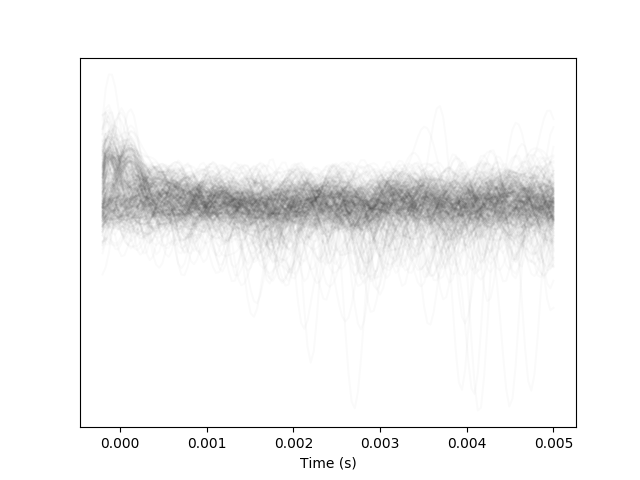

([], <a list of 0 Text yticklabel objects>)

In [14]:

plt.figure()
# css._align_spikes()
# css.pre_window = 0.005
# css.post_window = 0.005
plt.plot(np.linspace(-1.0*css.pre_window, css.post_window, css.aligned_spikes.shape[1]), css.aligned_spikes[1000:1310,:].T, alpha = 0.02, color='k')
plt.xlabel('Time (s)')
plt.yticks([])

In [81]:
freq_pca = css._extract_features()

In [82]:
freq_pca.shape

(60533, 10)

In [83]:
css.aligned_spikes.shape

(60533, 165)

In [37]:
[_,powers,xf] = css._find_max_powers()


In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(powers)
freq_pca = pca.transform(powers)


In [54]:
pca.components_.shape

(10, 15)

In [93]:
xf

array([   0.        ,  211.26760563,  422.53521127,  633.8028169 ,
        845.07042254, 1056.33802817, 1267.6056338 , 1478.87323944,
       1690.14084507, 1901.4084507 , 2112.67605634, 2323.94366197,
       2535.21126761, 2746.47887324, 2957.74647887])

In [103]:
y.shape

(10, 2958)

<IPython.core.display.Javascript object>


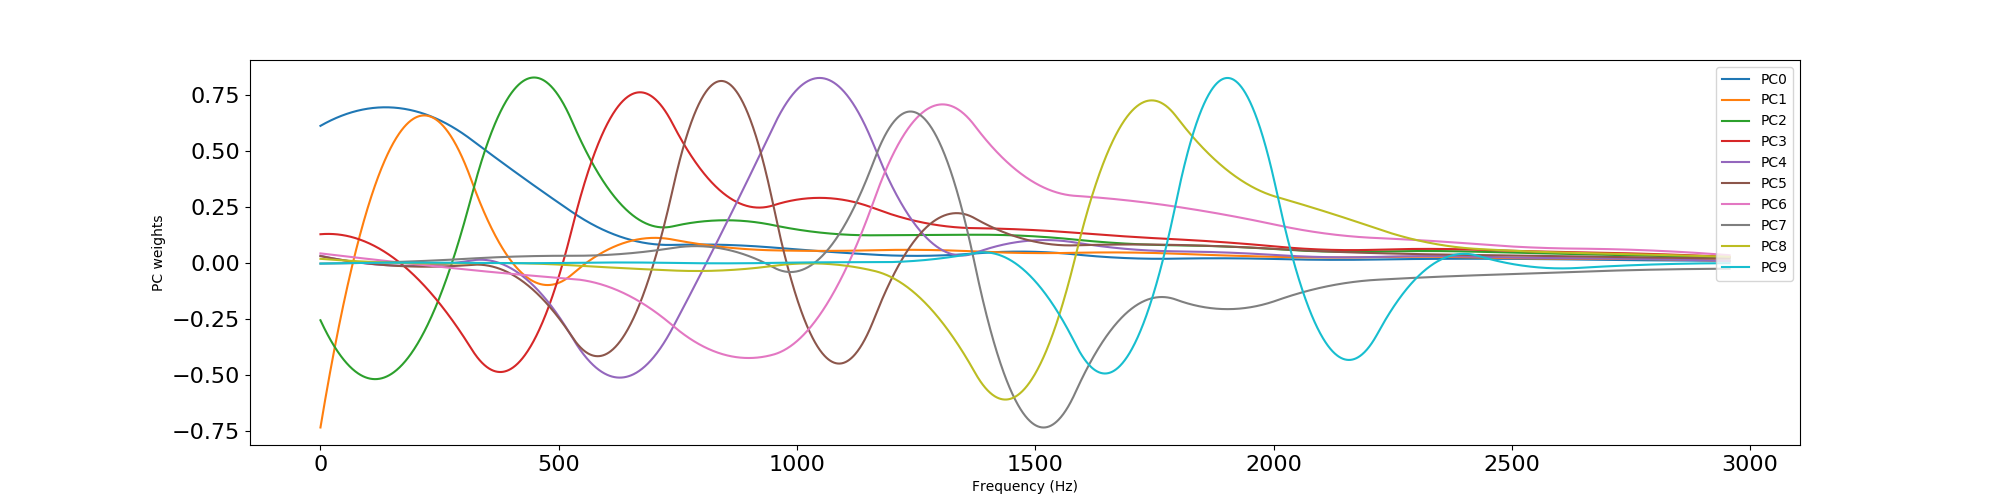

Text(0, 0.5, 'PC weights')

In [105]:
plt.figure(figsize=(20,5))
# plt.plot(xf, scipy.signal.savgol_filter( pca.components_[2,:], window_length=5, polyorder=2))
# plt.plot(xf, pca.components_[2,:])

f = scipy.interpolate.interp1d(xf, pca.components_ , kind='quadratic')
y = f(np.arange(xf[0],xf[-1]))
# plt.plot(f(np.arange(xf[0],xf[-1])))
plt.figure(figsize=(20,5))
plt.plot(y.T)
plt.legend(['PC{}'.format(i) for i in range(10)], loc='upper right')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PC weights')

In [106]:
plt.savefig('../data/plots/For_cssorter_paper/PC_weights.png')
plt.savefig('../data/plots/For_cssorter_paper/PC_weights.svg')

In [49]:
powers.shape

(60706, 15)

In [48]:
freq_pca.shape

(60706, 10)

<IPython.core.display.Javascript object>


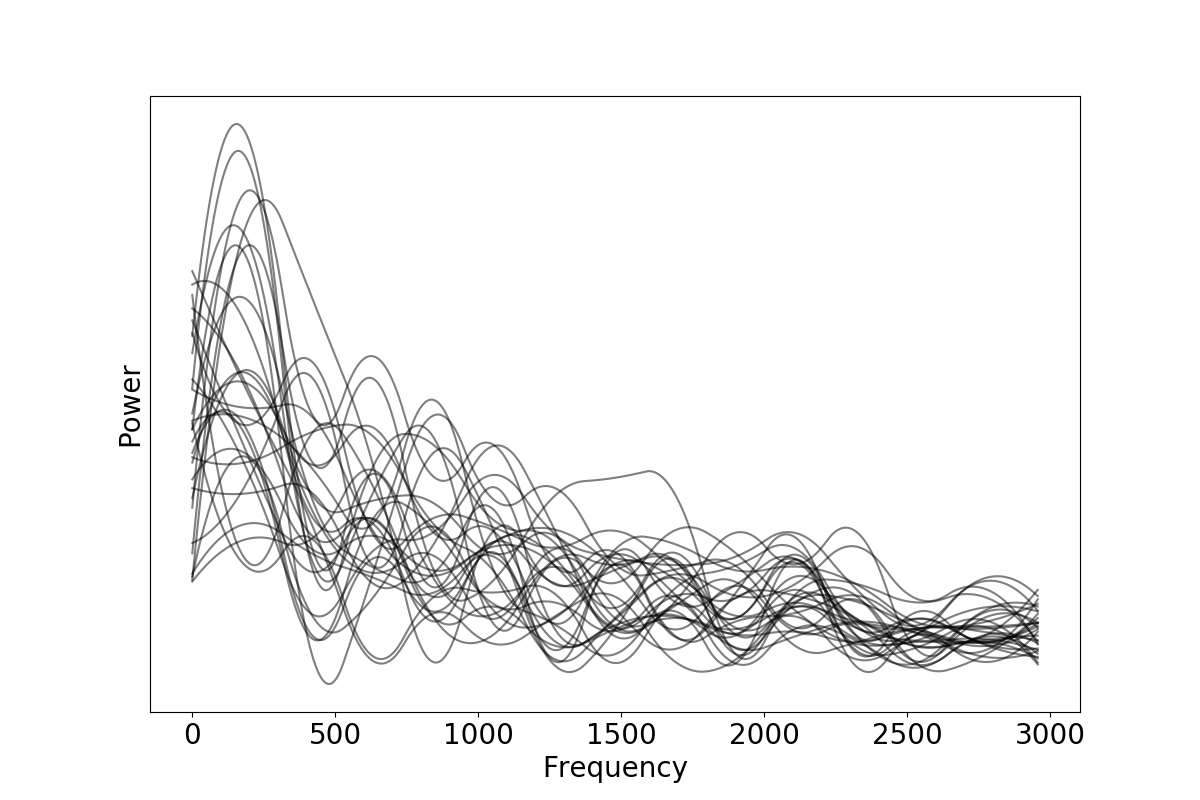

In [142]:
plt.figure(figsize=(12,8))
# css._align_spikes()
# css.pre_window = 0.005
# css.post_window = 0.005
f = scipy.interpolate.interp1d(xf, powers[50000:50030,:] , kind='quadratic')
y = f(np.arange(xf[0],xf[-1]))
plt.plot(y.T, alpha = 0.5, color='k')
plt.xlabel('Frequency', fontsize = 20)
plt.yticks([])
plt.ylabel('Power', fontsize = 20)
plt.rc('xtick',labelsize=20)

# plt.xticks(np.arange(10), ['PC{}'.format(i+1) for i in np.arange(10)])

In [143]:
plt.savefig('../data/plots/For_cssorter_paper/freqs_smooth.png', transparent=True)
plt.savefig('../data/plots/For_cssorter_paper/freqs_smooth.svg', transparent=True)

<IPython.core.display.Javascript object>


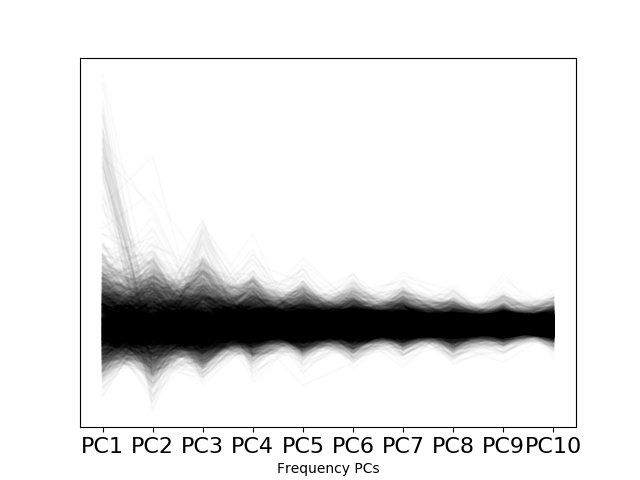

([<matplotlib.axis.XTick at 0x7f0d4c1db0f0>,
 <a list of 10 Text xticklabel objects>)

In [40]:
plt.figure()
# css._align_spikes()
# css.pre_window = 0.005
# css.post_window = 0.005
plt.plot(np.arange(10), freq_pca[50000:53100,:].T, alpha = 0.02, color='k')
plt.xlabel('Frequency PCs')
plt.yticks([])
plt.xticks(np.arange(10), ['PC{}'.format(i+1) for i in np.arange(10)])

In [90]:
plt.savefig('../data/plots/For_cssorter_paper/freq_PCs.png', transparent=True)
plt.savefig('../data/plots/For_cssorter_paper/freq_PCs.svg', transparent=True)

In [13]:
# css.voltage_filtered = np.copy(css.voltage)
# [b, a] = scipy.signal.filter_design.butter(css.filter_order,
#              [2 * css.dt * css.high_pass_filter_cutoff, 2 * css.dt * css.low_pass_filter_cutoff],
#                                     btype='bandpass')
# css.voltage_filtered = scipy.signal.lfilter(b, a, css.voltage_filtered)  # Filter forwards
# # voltage_filteredud1 = np.copy(css.voltage_filtered)
# # voltage_filteredud1 = np.flipud(voltage_filteredud1)
# css.voltage_filtered = np.flipud(css.voltage_filtered)
# css.voltage_filtered = scipy.signal.lfilter(b, a, css.voltage_filtered)  # Filter reverse
# css.voltage_filtered = np.flipud(css.voltage_filtered)
# # css.voltage_filtered = scipy.signal.filtfilt(b,a,css.voltage_filtered)

In [14]:
# css.voltage_filtered = scipy.signal.savgol_filter(css.voltage_filtered, 5, 2, 1, css.dt)

In [92]:
prange = [-3000000,-1]
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, prange[0]:prange[1]], dt)
css.pre_window = 0.0002
css.post_window = 0.005
css.num_gmm_components = 5
css.gmm_cov_type = 'tied'
css._init_gmm()
css._pre_process()
css._detect_spikes_minibatch()
# css.run()

Using minibatch spike detection, batch size = 50s


In [ ]:
peak_times,_ = scipy.signal.find_peaks(voltage_signal[all_spike_indices])
spike_indices = all_spike_indices[peak_times]
first_index = spike_indices[0]
spike_peaks = np.array([np.argmin(signal_unfiltered[max(0, si - int(0.0005/self.dt)) : si + int(0.002/self.dt)]) for si in spike_indices])
spike_indices = spike_indices + spike_peaks - int(0.0005/self.dt)
# in case the first window is less then the 0.0005/dt
if spike_indices[0] < 0:
    spike_indices[0] = spike_peaks[0]


In [40]:
import scipy.signal

In [44]:
peaks,_ = scipy.signal.find_peaks(css.voltage[css.spike_indices])

<IPython.core.display.Javascript object>


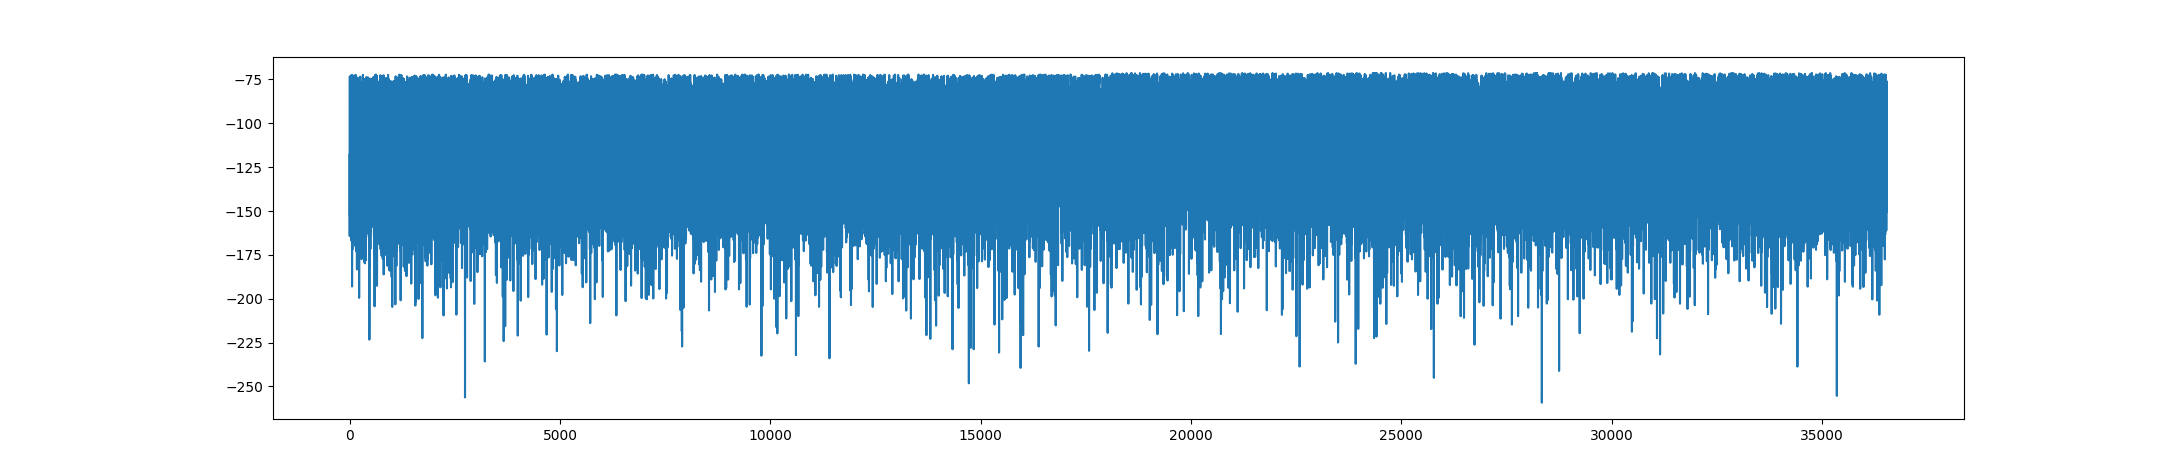

In [47]:
plt.figure()
plt.plot(css.voltage[css.spike_indices])

<IPython.core.display.Javascript object>


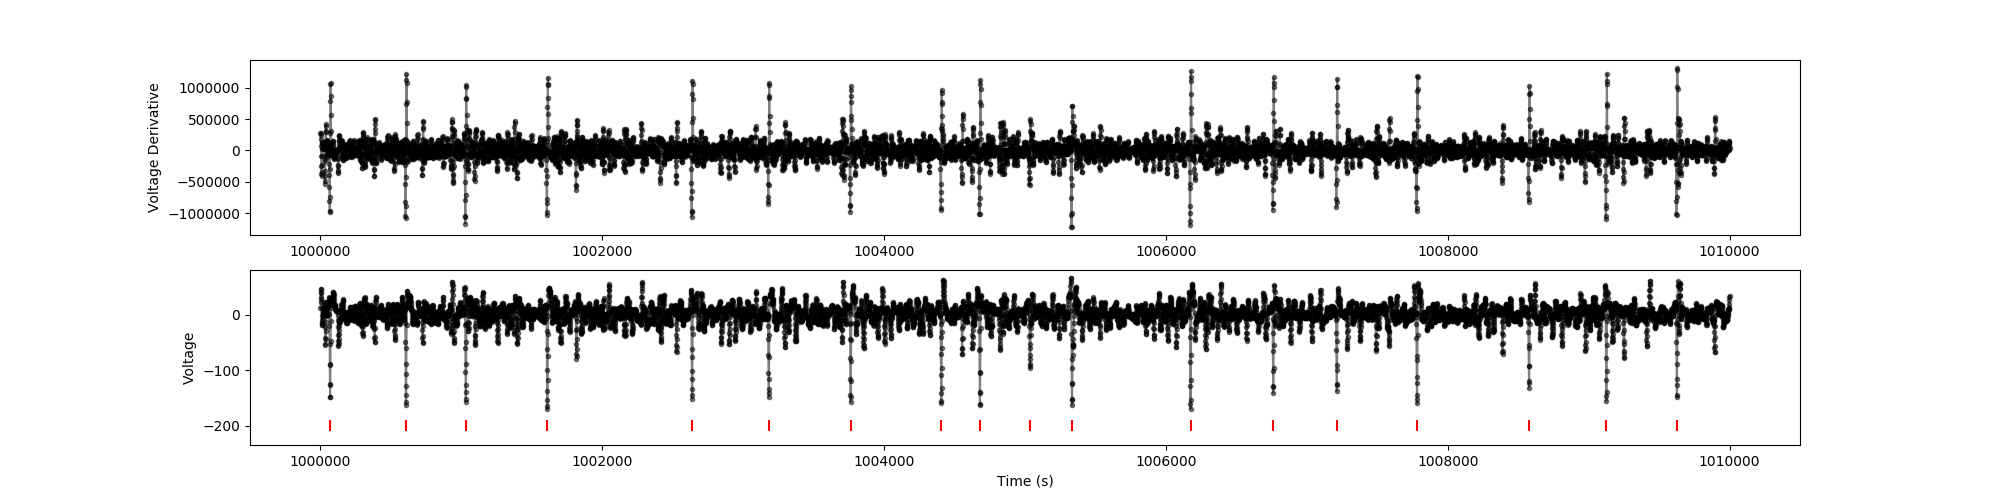

In [105]:
plt.figure(figsize=(20,5))

# t = np.arange(prange[0],prange[1])*css.dt
# plt.plot(t, css.voltage[prange[0]:prange[1]:1]*5000, alpha = 0.8, color = 'k')
# plt.plot(t, css.voltage_filtered, alpha = 0.8, color = 'r')
plt.subplot(211)
plt.plot(np.arange(1000000,1010000), css.voltage_filtered[1000000:1010000],'.-', alpha = 0.5, color='k')
plt.ylabel('Voltage Derivative')
# plt.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices<1010000, css.spike_indices>1000000))], linelengths=100000, lineoffsets=-1310000 , colors='r', zorder=10)
plt.subplot(212)
plt.plot(np.arange(1000000,1010000), css.voltage[1000000:1010000],'.-', alpha = 0.5, color='k')
plt.xlabel('Time (s)')
# plt.yticks([])
plt.ylabel('Voltage')
plt.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices<1010000, css.spike_indices>1000000))], linelengths=20, lineoffsets=-200 , colors='r', zorder=10)
# plt.legend(['Raw', 'Processed'])
# plt.plot(voltage_filteredud1[200000::5], alpha = 0.5, color = 'k')
# plt.eventplot(css.spike_indices,linelengths=20,lineoffsets=-250,  linewidths=2, colors='r', zorder=10)


In [106]:
plt.savefig('../data/plots/tmp/derivative-vs-voltage_gmm_on_voltage.png')

In [17]:
spike_indices = css.get_spike_indices()
plt_spike_indices = np.where(np.logical_and(spike_indices<=prange[1]+1 , spike_indices>=prange[0]))
plt_spike_indices = spike_indices[plt_spike_indices]
# plt.plot(plt_spike_indices*dt, css.voltage[plt_spike_indices],'*r' , zorder=10)
plt.eventplot(plt_spike_indices*dt,linelengths=300000,lineoffsets=-1100000, linewidths=2, colors='r', zorder=10)

In [31]:
image_fname = '../data/plots/For_cssorter_paper/filtered-signal_derivative' 
plt.savefig(image_fname + '.png')
plt.savefig(image_fname + '.svg')


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=True, weights_init=None)

(5, 3631721)

In [55]:
css.gmm.means_.flatten().shape

(3,)

<IPython.core.display.Javascript object>


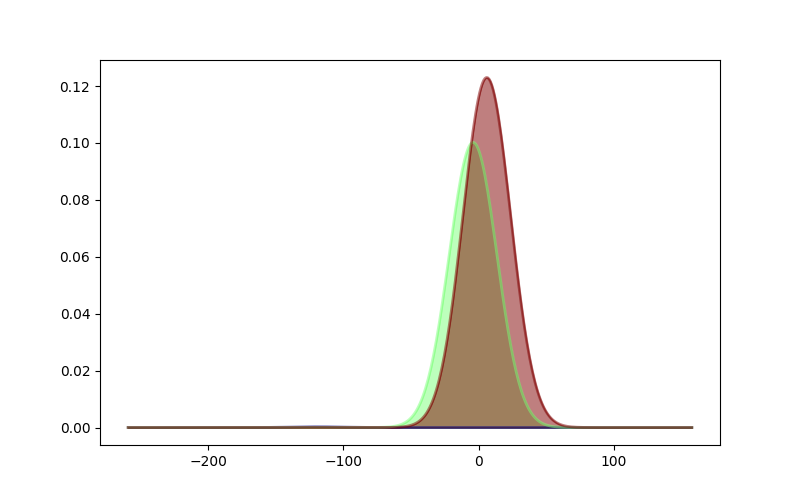

IndexError: index 3 is out of bounds for axis 0 with size 3

In [54]:
# plot gaussian mixture for the spike detection
from scipy.stats import norm
plt.figure(figsize=(8,5))
# uniq = np.unique(ss.d_voltage[prang] , return_counts=True)
x = np.arange(np.min(css.voltage_filtered), np.max(css.voltage_filtered), 1)
gauss_mixt = np.array([p * norm.pdf(x, mu, np.sqrt(css.gmm.covariances_.flatten())) for mu, p in zip(css.gmm.means_.flatten(), css.gmm.weights_)])
# gauss_mixt = np.array([p * norm.pdf(x, mu, sd) for mu, sd, p in zip(css.gmm.means_.flatten(), np.sqrt(css.gmm.covariances_.flatten()), css.gmm.weights_)])

colors = plt.cm.jet(np.linspace(0,1,len(gauss_mixt)))

# plot histogram overlaid by css.gmm gaussians
# plt.hist(css.voltage_filtered.reshape(-1,1),bins=256,density=True, color='gray', alpha = 0.3)
# for i, gmixt in enumerate(gauss_mixt):
#     plt.plot(x, gmixt, label = 'Gaussian '+str(i), color = colors[i], linewidth=2)

    
# #     plt.eventplot(css.gmm.means_, linelength=np.max(np.max(power_feature)))
#     plt.show()
plt.plot(x,gauss_mixt[0], color=colors[0], linewidth = 2 , alpha = 0.5)
plt.fill_between(x , 0, gauss_mixt[0], color=colors[0], alpha = 0.5)
plt.plot(x,gauss_mixt[1]*10, color=colors[1], linewidth = 2, alpha = 0.5)
plt.fill_between(x , 0, gauss_mixt[1]*10, color=colors[1], alpha = 0.5)
plt.plot(x,gauss_mixt[2]*10, color=colors[2], linewidth = 2, alpha = 0.5)
plt.fill_between(x , 0, gauss_mixt[2]*10, color=colors[2], alpha = 0.5)
plt.plot(x,gauss_mixt[3]*10, color=colors[3], linewidth = 2, alpha = 0.5)
plt.fill_between(x , 0, gauss_mixt[3]*10, color=colors[3], alpha = 0.5)
plt.plot(x,gauss_mixt[4]*10, color=colors[4], linewidth = 2, alpha = 0.5)
plt.fill_between(x , 0, gauss_mixt[4]*10, color=colors[4], alpha = 0.5)
plt.xticks([])
plt.yticks([])

    

In [80]:
plt.savefig('../data/plots/For_cssorter_paper/5Gaussians.png', transparent=True)
plt.savefig('../data/plots/For_cssorter_paper/5Gaussians.svg', transparent=True)

In [8]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
chan_data_raw = np.load(chan_filtered_fname)
Fs = 30000.0

### Plot channel voltage

In [43]:
# plot channel
# plt.figure(figsize=(16,5))
# plt.plot(chan_data[chan_index, :])
# plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [74]:
from cssorter.spikesorter import ComplexSpikeSorter
Fs = 30000.0
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.cs_num_gmm_components = 3
css.run()
print(css.cs_indices.shape)

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

Pre-process time = 0.9118859767913818
Using minibatch spike detection, batch size = 50s
Spike detection time = 91.17269349098206
Align spikes time = 93.31669521331787
CS spike detection time = 117.84800815582275
CS post process time = 119.90704798698425
(2501,)


In [107]:
features = css._extract_features()

In [110]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(css.cs_num_gmm_components, covariance_type = css.cs_cov_type, random_state=0).fit(features)
cluster_labels = gmm.predict(features)

In [116]:
np.mean(gmm.means_, axis=1)

array([ 1.2262524 ,  3.74891847, -0.14454852, -0.53728697, -1.17967117])

<IPython.core.display.Javascript object>


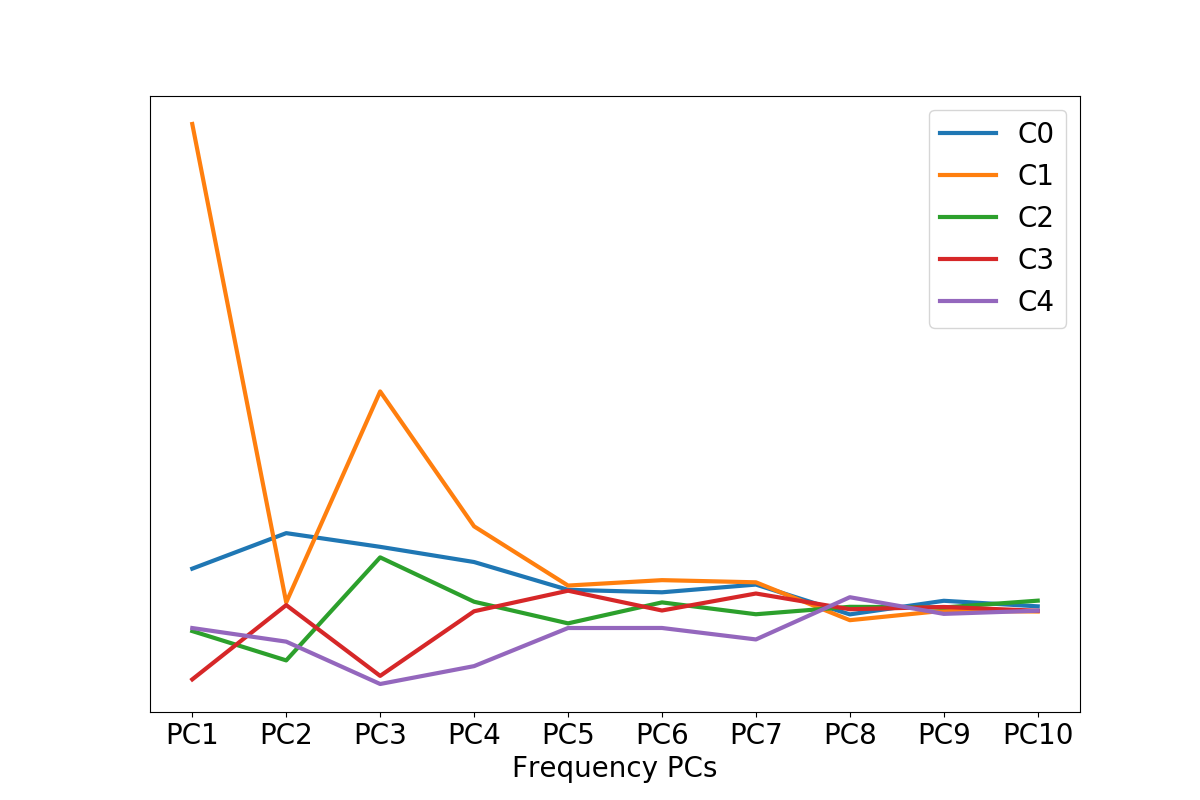

In [129]:
plt.figure(figsize=(12,8))
plt.plot(gmm.means_.T, linewidth=3)
plt.xlabel('Frequency PCs', fontsize=20)
plt.yticks([])
plt.xticks(np.arange(10), ['PC{}'.format(i+1) for i in np.arange(10)], fontsize=20)
plt.legend(['C{}'.format(i) for i in range(gmm.n_components)], fontsize=20)
plt.savefig('../data/plots/For_cssorter_paper/PC_means.png')
plt.savefig('../data/plots/For_cssorter_paper/PC_means.svg')

In [9]:
[max_powers, powers, xf] = css._find_max_powers()

In [10]:
powers.shape

(60706, 15)

In [11]:
spike_indices = css.get_spike_indices()


In [12]:
css.cs_indices

array([  197685,   201193,   271268, ..., 35953449, 35958009, 35984478])

In [13]:
cs_power_ids = np.where(np.isin(css.get_spike_indices(), css.cs_indices))[0]
ss_power_ids = np.where( np.logical_not(np.isin(css.get_spike_indices(), css.cs_indices)))[0]

In [14]:
ss_power_ids

array([    0,     1,     2, ..., 60703, 60704, 60705])

<IPython.core.display.Javascript object>


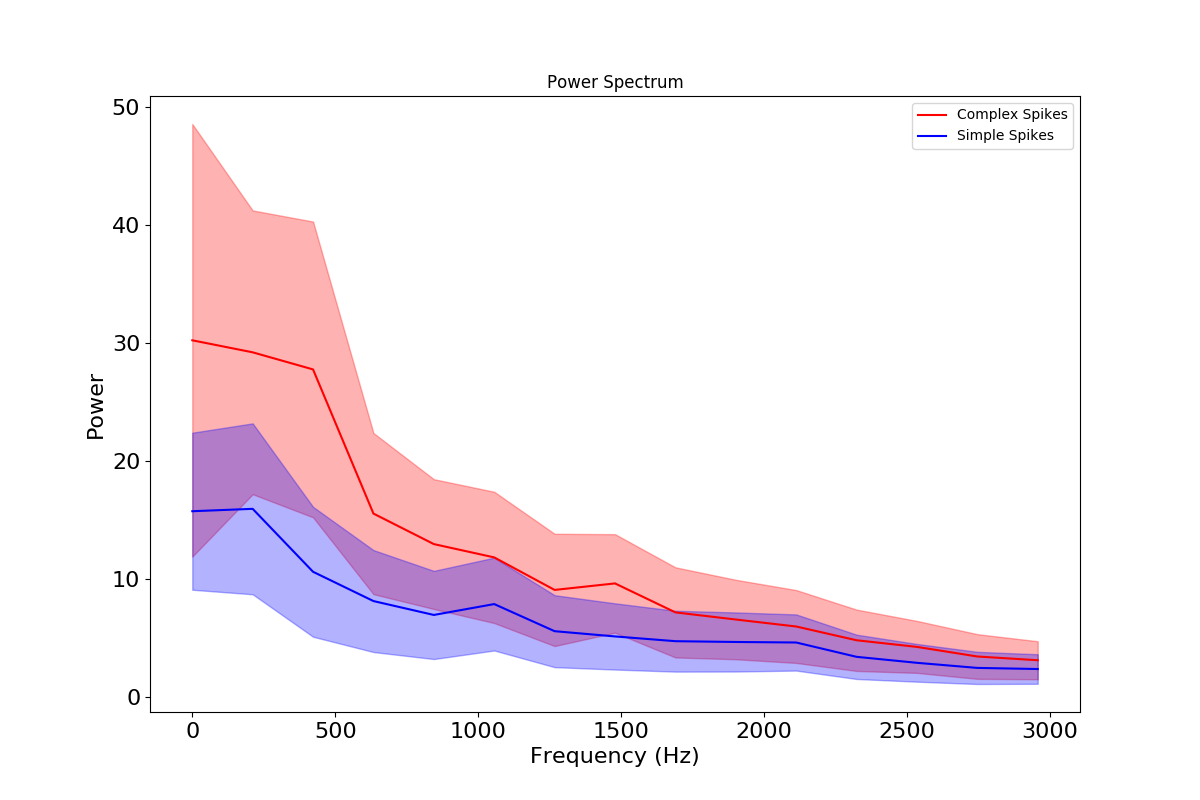

Text(0.5, 1.0, 'Power Spectrum')

In [35]:
plt.figure(figsize=(12,8))
mean_powers_cs = np.mean(powers[cs_power_ids,:], axis = 0)
se_powers_cs = np.std(powers[cs_power_ids,:], axis = 0)

mean_powers_ss = np.mean(powers[ss_power_ids,:], axis = 0)
se_powers_ss = np.std(powers[ss_power_ids,:], axis = 0)

plt.plot(xf, mean_powers_cs, 'r')
plt.fill_between(xf, mean_powers_cs - se_powers_cs, mean_powers_cs + se_powers_cs, alpha = 0.3, color = 'r')
plt.plot(xf, mean_powers_ss, 'b')
plt.fill_between(xf, mean_powers_ss - se_powers_ss, mean_powers_ss + se_powers_ss, alpha = 0.3, color = 'b')

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.ylabel('Power', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.legend(['Complex Spikes', 'Simple Spikes'])
plt.title('Power Spectrum')

In [36]:
plt.savefig('../data/plots/For_cssorter_paper/Frequency_spectrum-from-0.0002-0.005-bandpass-100-3000.png', transparent=True)
plt.savefig('../data/plots/For_cssorter_paper/Frequency_spectrum-from-0.0002-0.005-bandpass-100-3000.svg', transparent=True)

In [39]:
from cssorter.spikesorter import ComplexSpikeSorter
Fs = 30000.0
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.pre_window = 0.0002
css.post_window = 0.005
css.num_gmm_components=3
css.cs_num_gmm_components = 3
css.run()
print(css.cs_indices.shape)

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

Pre-process time = 0.912102460861206
Using minibatch spike detection, batch size = 50s
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage

In [114]:
aligned_cs.shape

(16, 135)

In [40]:
num_clusters = 8
pre_time = 0.0005
post_time = 0.005
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time, align_to='min')
ss_indices = css.get_ss_indices()

In [41]:
ss_indices.shape

(125579,)

In [42]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [43]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

Total run time = 4902.068749904633 s


<IPython.core.display.Javascript object>


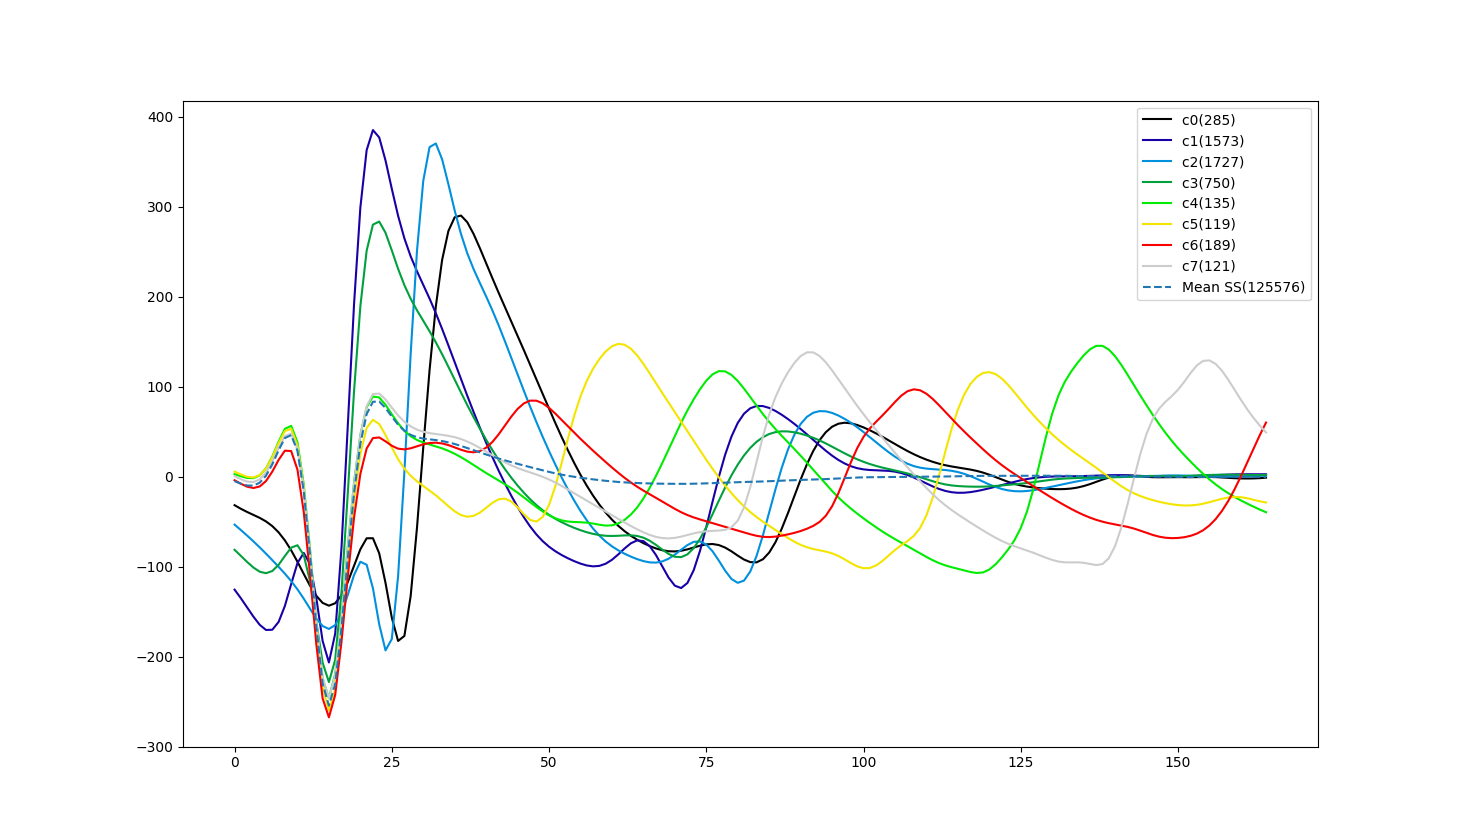

In [44]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
plt.legend() 

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

Detected CS clusters: [0 2]


In [53]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 0,1,2,3


In [54]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (4335,)


## Saving detected CS and SS:

In [ ]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

In [25]:
import csv
with open(os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index)), 'r') as f:
    f.seek(0)
    csvreader = csv.reader(f, delimiter = ',')
    cs_indices_no_lfp = np.squeeze(np.array(list(csvreader), dtype=np.int64))

FileNotFoundError: [Errno 2] No such file or directory: '../data/OpenEphys_data/2019-04-26/2019-04-26_12-03-55/channel_4.CS.csv'

<IPython.core.display.Javascript object>


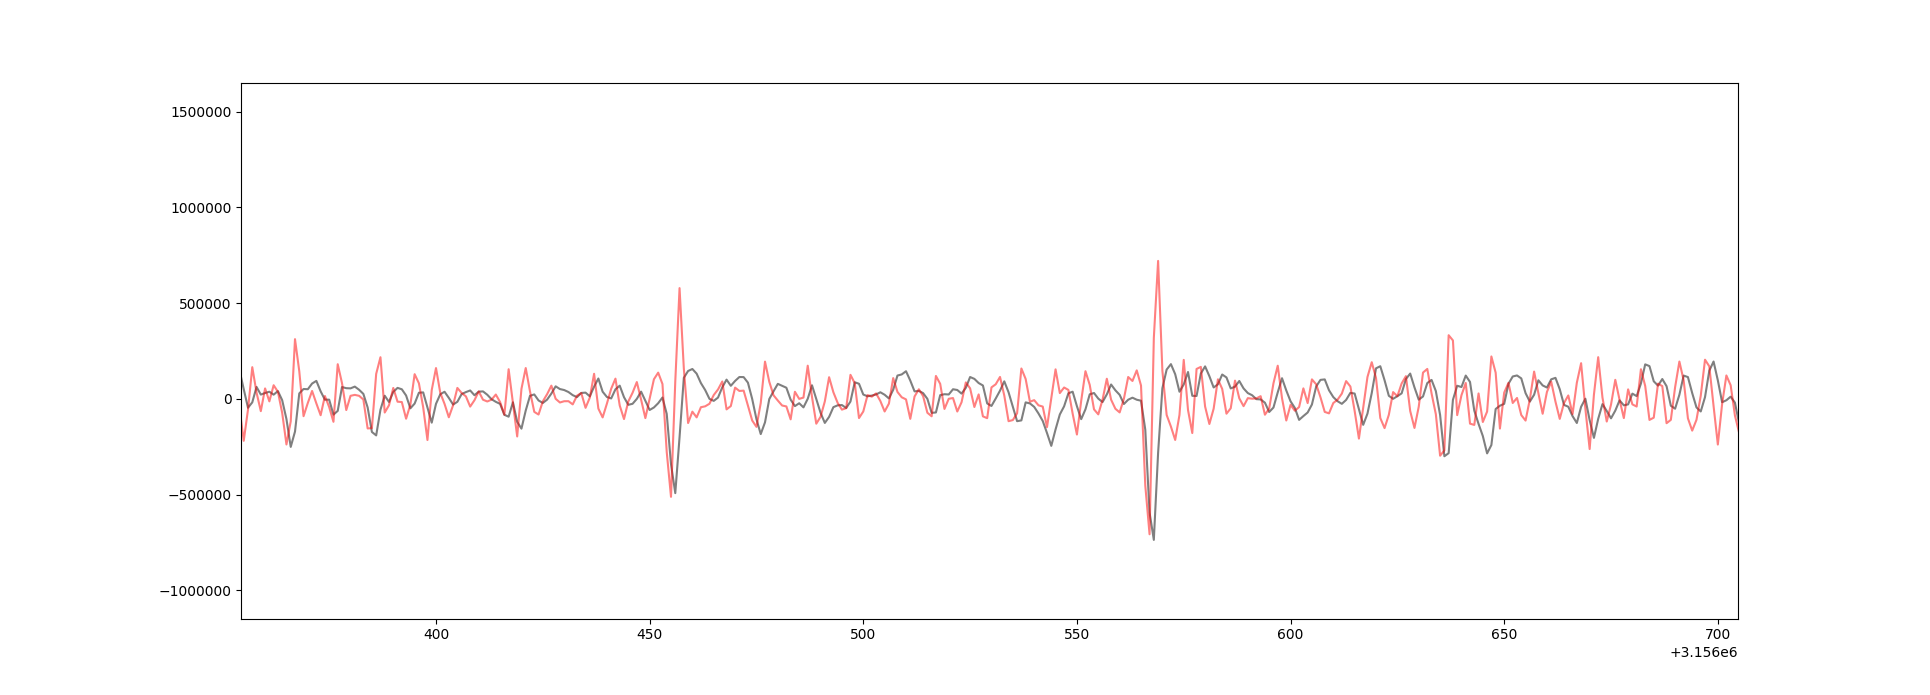

<IPython.core.display.Javascript object>


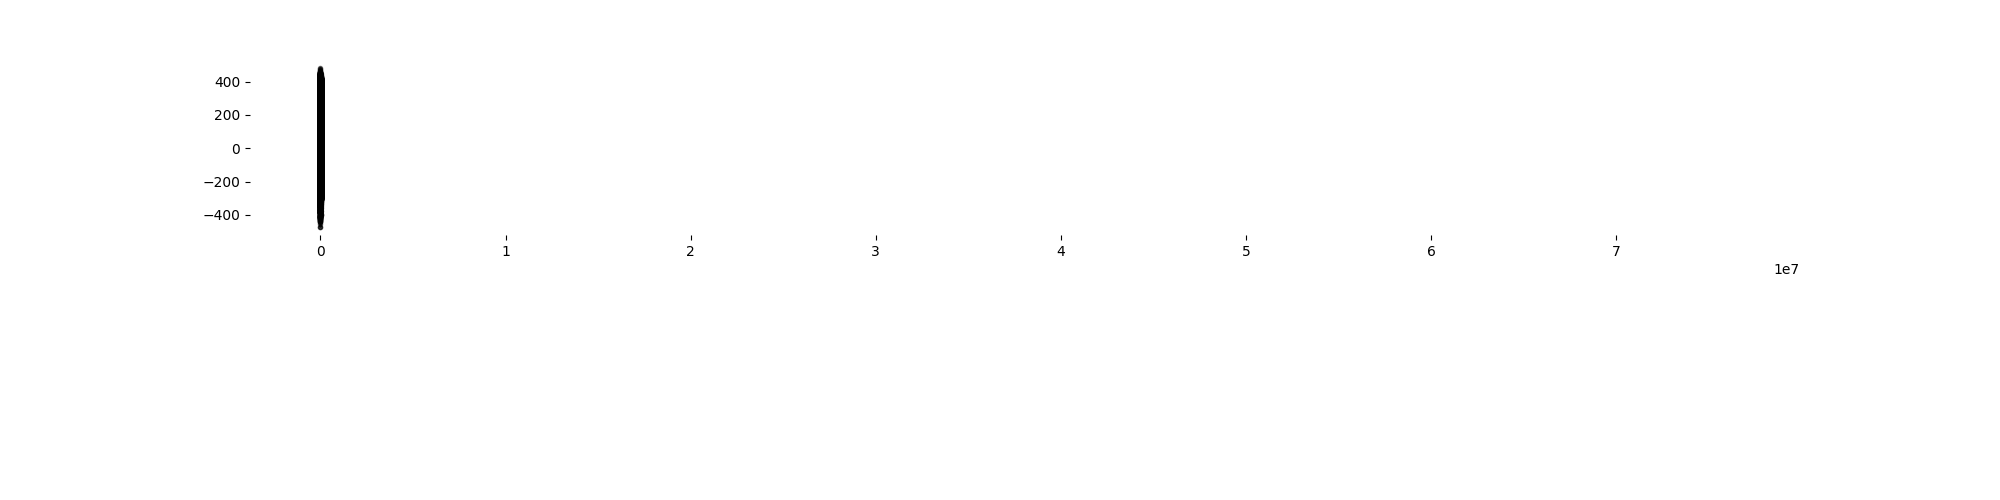

In [35]:
prange = [0, css.voltage.size]
plt.figure(figsize=(20,5))
# plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)
ax1 = plt.subplot(211)
plt.plot(np.arange(prange[0], prange[1])*css.dt,css.voltage[prange[0]: prange[1]],'.-' , alpha = 0.5, color='k')
plt.subplot(212, sharex=ax1)
plt.plot(np.arange(prange[0], prange[1])*css.dt,css.voltage_filtered[prange[0]: prange[1]],'.-' ,alpha = 0.5, color='k')
plt.eventplot(cs_indices, linelengths=400, colors='r')

# plt.eventplot(cs_indices_no_lfp, linelengths=700, colors='y', alpha=0.5)


0.0033333333333333335

In [107]:
np.arange(csi-int(0.200*Fs) , csi+int(0.200*Fs)).shape

(12000,)

<IPython.core.display.Javascript object>


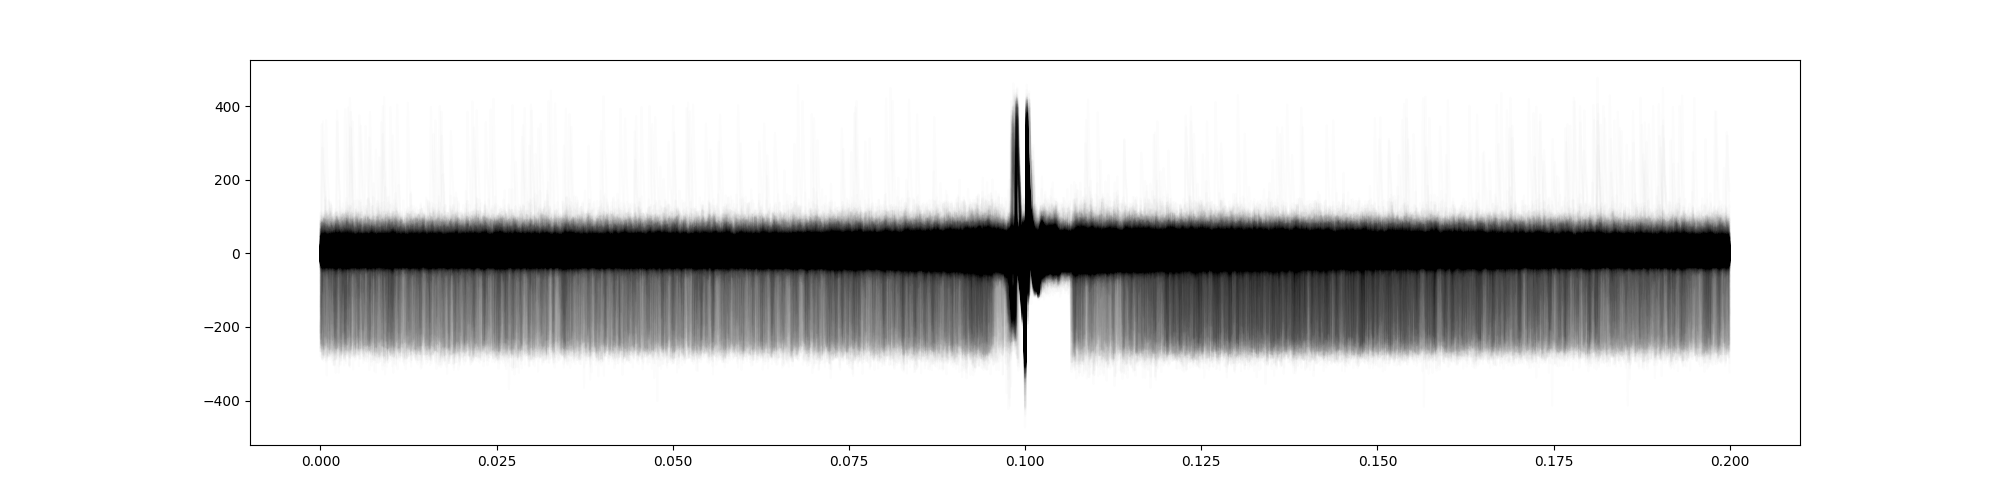

5.306900000000001


In [36]:
plt.figure(figsize=(20,5))
csi = cs_indices[7]
print(csi*dt)
for csi in cs_indices:
    plt.plot(np.arange(0, 0.200, dt), css.voltage[csi-int(0.100*Fs) : csi+int(0.100*Fs)], color='k', alpha=0.01)



In [160]:
150*dt

0.005

<IPython.core.display.Javascript object>


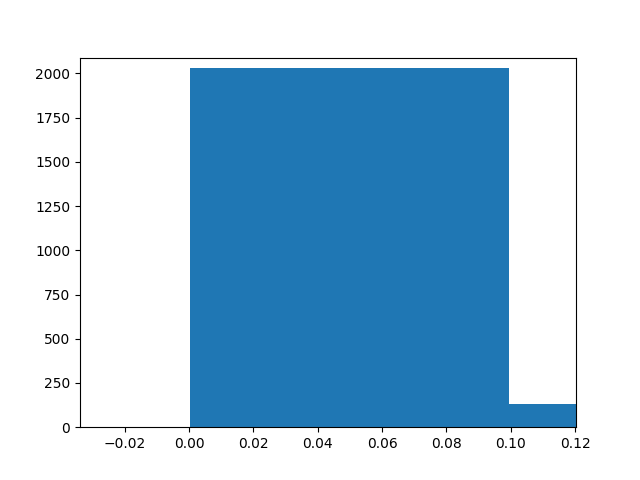

(array([2.031e+03, 1.320e+02, 1.550e+02, 1.610e+02, 1.880e+02, 1.420e+02,
        1.140e+02, 1.200e+02, 1.250e+02, 1.100e+02, 1.120e+02, 9.800e+01,
        9.200e+01, 8.900e+01, 6.000e+01, 6.600e+01, 5.900e+01, 4.700e+01,
        5.200e+01, 4.700e+01, 4.000e+01, 3.700e+01, 2.900e+01, 3.100e+01,
        3.000e+01, 2.100e+01, 2.600e+01, 1.200e+01, 1.600e+01, 1.400e+01,
        1.100e+01, 1.000e+01, 1.100e+01, 5.000e+00, 4.000e+00, 4.000e+00,
        4.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

In [55]:
plt.figure()
plt.hist(np.diff(cs_indices)*dt, bins=100)

<IPython.core.display.Javascript object>


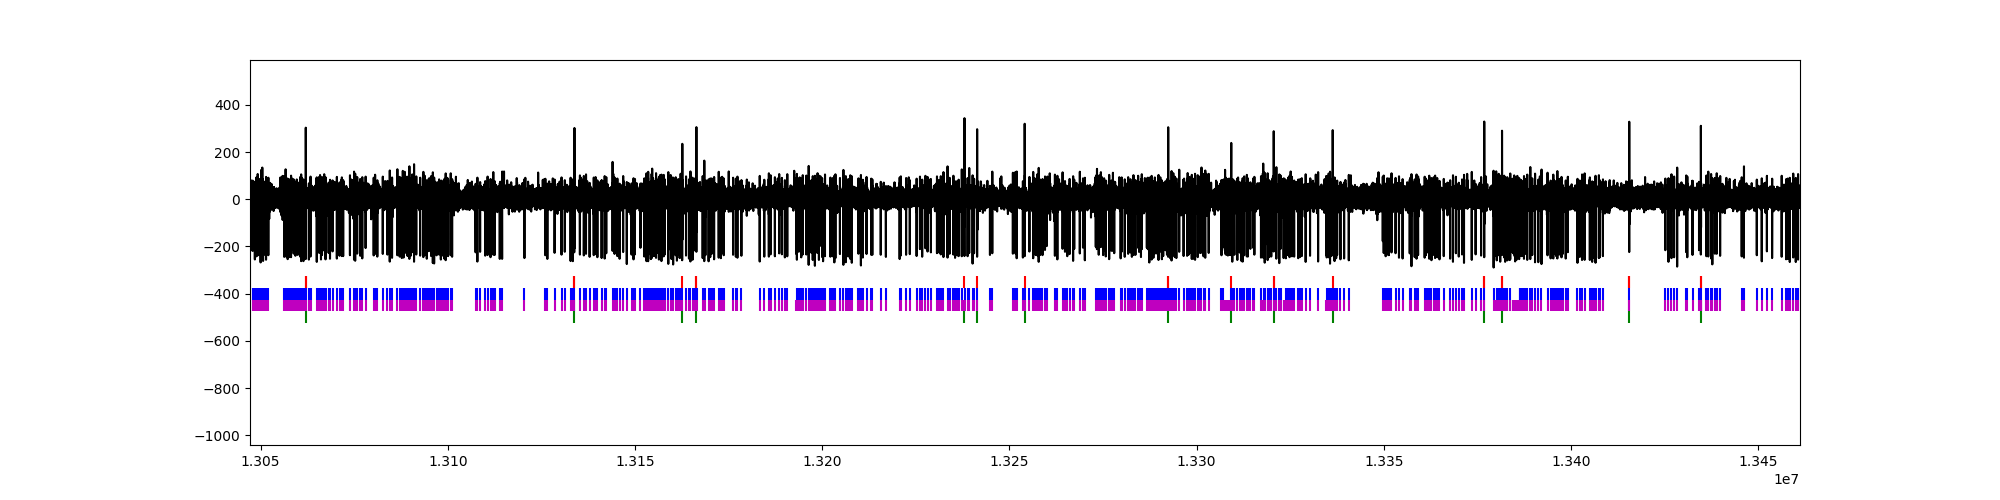

In [94]:
plt.figure(figsize=(20,5))
plt.plot(css.voltage[0:int(500*Fs)], color = 'k')
ss_indices = css.get_spike_indices()
plt.eventplot(cs_indices[np.where(cs_indices < 500*Fs+ 1)], linelengths=50, lineoffsets=-350, color='r')
plt.eventplot(ss_indices[np.where(ss_indices < 500*Fs+ 1)], linelengths=50, lineoffsets=-400, color='b')
plt.eventplot(css.spike_indices[np.where(css.spike_indices < 500*Fs+ 1)], linelengths=50, lineoffsets=-450, color='m')
plt.eventplot(cs_new[np.where(cs_new < 500*Fs+ 1)], linelengths=50, lineoffsets=-500, color='g')

In [89]:
import scipy.spatial as spatial
point_tree = spatial.cKDTree(cs_indices.reshape(-1,1))

In [90]:
point_tree.query_ball_point(cs_indices[2],1)

IndexError: tuple index out of range

In [66]:
#Merge CS overlaps

pre_index = int(np.round(0.005 / dt))
post_index = int(np.round(0.005 / dt))
cs_new = []
for i, csi in enumerate(cs_indices[1:]):
    if (csi - pre_index) <=(cs_indices[i] + post_index) or cs_indices[i] - pre_index < 0:
        cs_align_pt = np.argmin(css.voltage[cs_indices[i] - pre_index: csi + post_index]) + cs_indices[i] - pre_index
        cs_new.append(cs_align_pt)
    else:
        cs_new.append(csi)
# if self.spike_indices[-1] + post_index >= self.voltage.size:
#     to_delete = to_delete + [self.spike_indices.size - 1]
# #         if self.spike_indices[0] - pre_index < 0:
# #             to_delete = [0] + to_delete
# mask = np.ones(self.spike_indices.shape, dtype=bool)
# mask[to_delete] = False
# no_overlap_spike_indices = self.spike_indices[mask]
cs_new = np.array(cs_new)

In [102]:
csiss = np.diff(cs_indices)
# cs_dups = cs_indices[np.where(csiss<0.010*Fs)]
cs_new = np.delete(cs_indices, np.where(csiss<0.010*Fs))

In [103]:
cs_new.shape

(2329,)

In [27]:
css.cs_indices = cs_indices

In [28]:
cs_indices = css.get_cs_spike_indices()
ss_indices = css.get_ss_indices()

In [29]:
SS = np.zeros(np.int64(css.signal_size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(css.signal_size/30.0))
CS[np.int64(cs_indices/30.0)] = 1

<IPython.core.display.Javascript object>


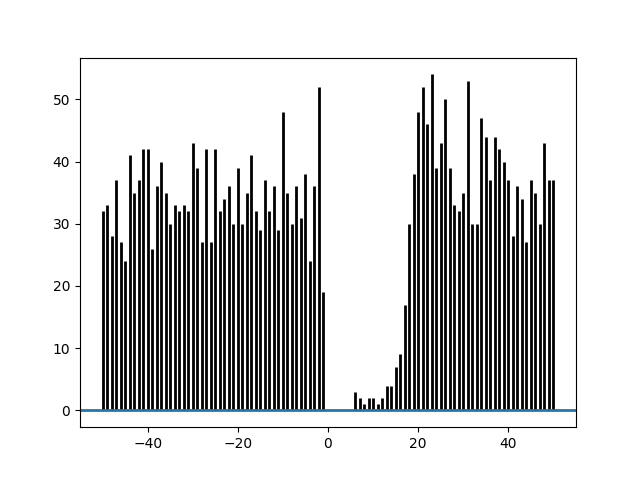

In [30]:
plt.figure()
xcor_ret = plt.xcorr(SS, CS, usevlines=True, maxlags=50, normed=False, lw=2)

<IPython.core.display.Javascript object>


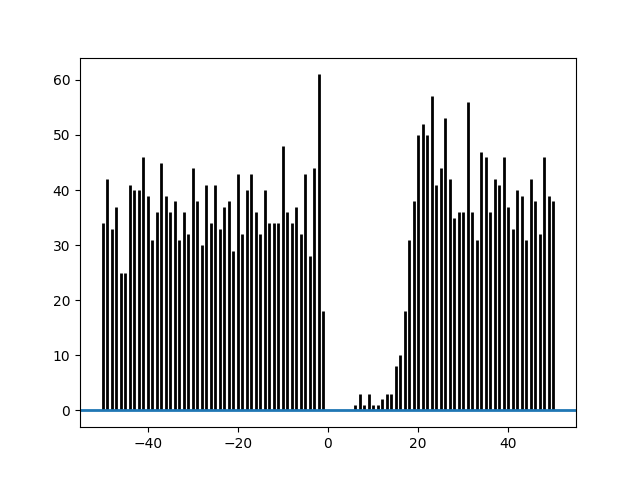

In [37]:
plt.figure()
xcor_ret = plt.xcorr(SS, CS, usevlines=True, maxlags=50, normed=False, lw=2)

In [16]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/30000
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)


In [17]:
css._pre_process()

In [34]:
prange = [3000000, 6008000]

<IPython.core.display.Javascript object>


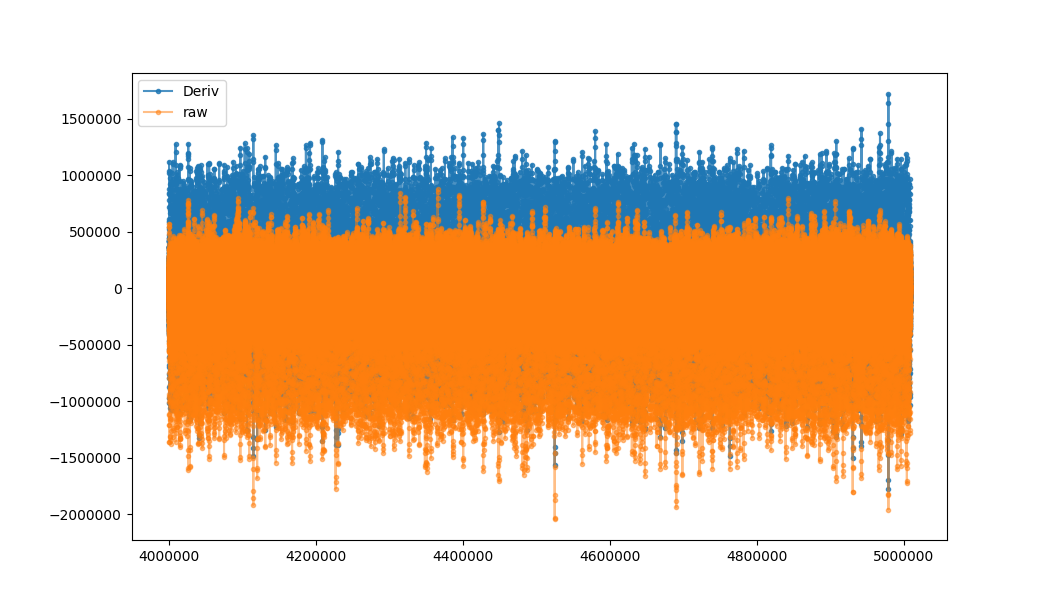

In [27]:
t = np.arange(prange[0],prange[1])*css.dt
plt.figure()
plt.plot(np.arange(prange[0], prange[1]), css.voltage_filtered[prange[0]:prange[1]],'.-',  alpha = 0.8)
plt.plot(np.arange(prange[0], prange[1]), css.voltage[prange[0]:prange[1]]*8000,'.-' ,alpha = 0.5)
# plt.plot(np.arange(1000000, 1008000), css.voltage_filt_derivative[1000000:1008000:1],'.-',  alpha = 0.5)
# plt.plot(np.arange(1000000, 1008000), css.voltage_raw_derivative[1000000:1008000:1],'.-',  alpha = 0.5)
# plt.legend(['Internal band-pass filtered', 'raw', 'filtered&derivative', 'Raw&derivative'])
plt.legend(['Deriv', 'raw'])

<IPython.core.display.Javascript object>


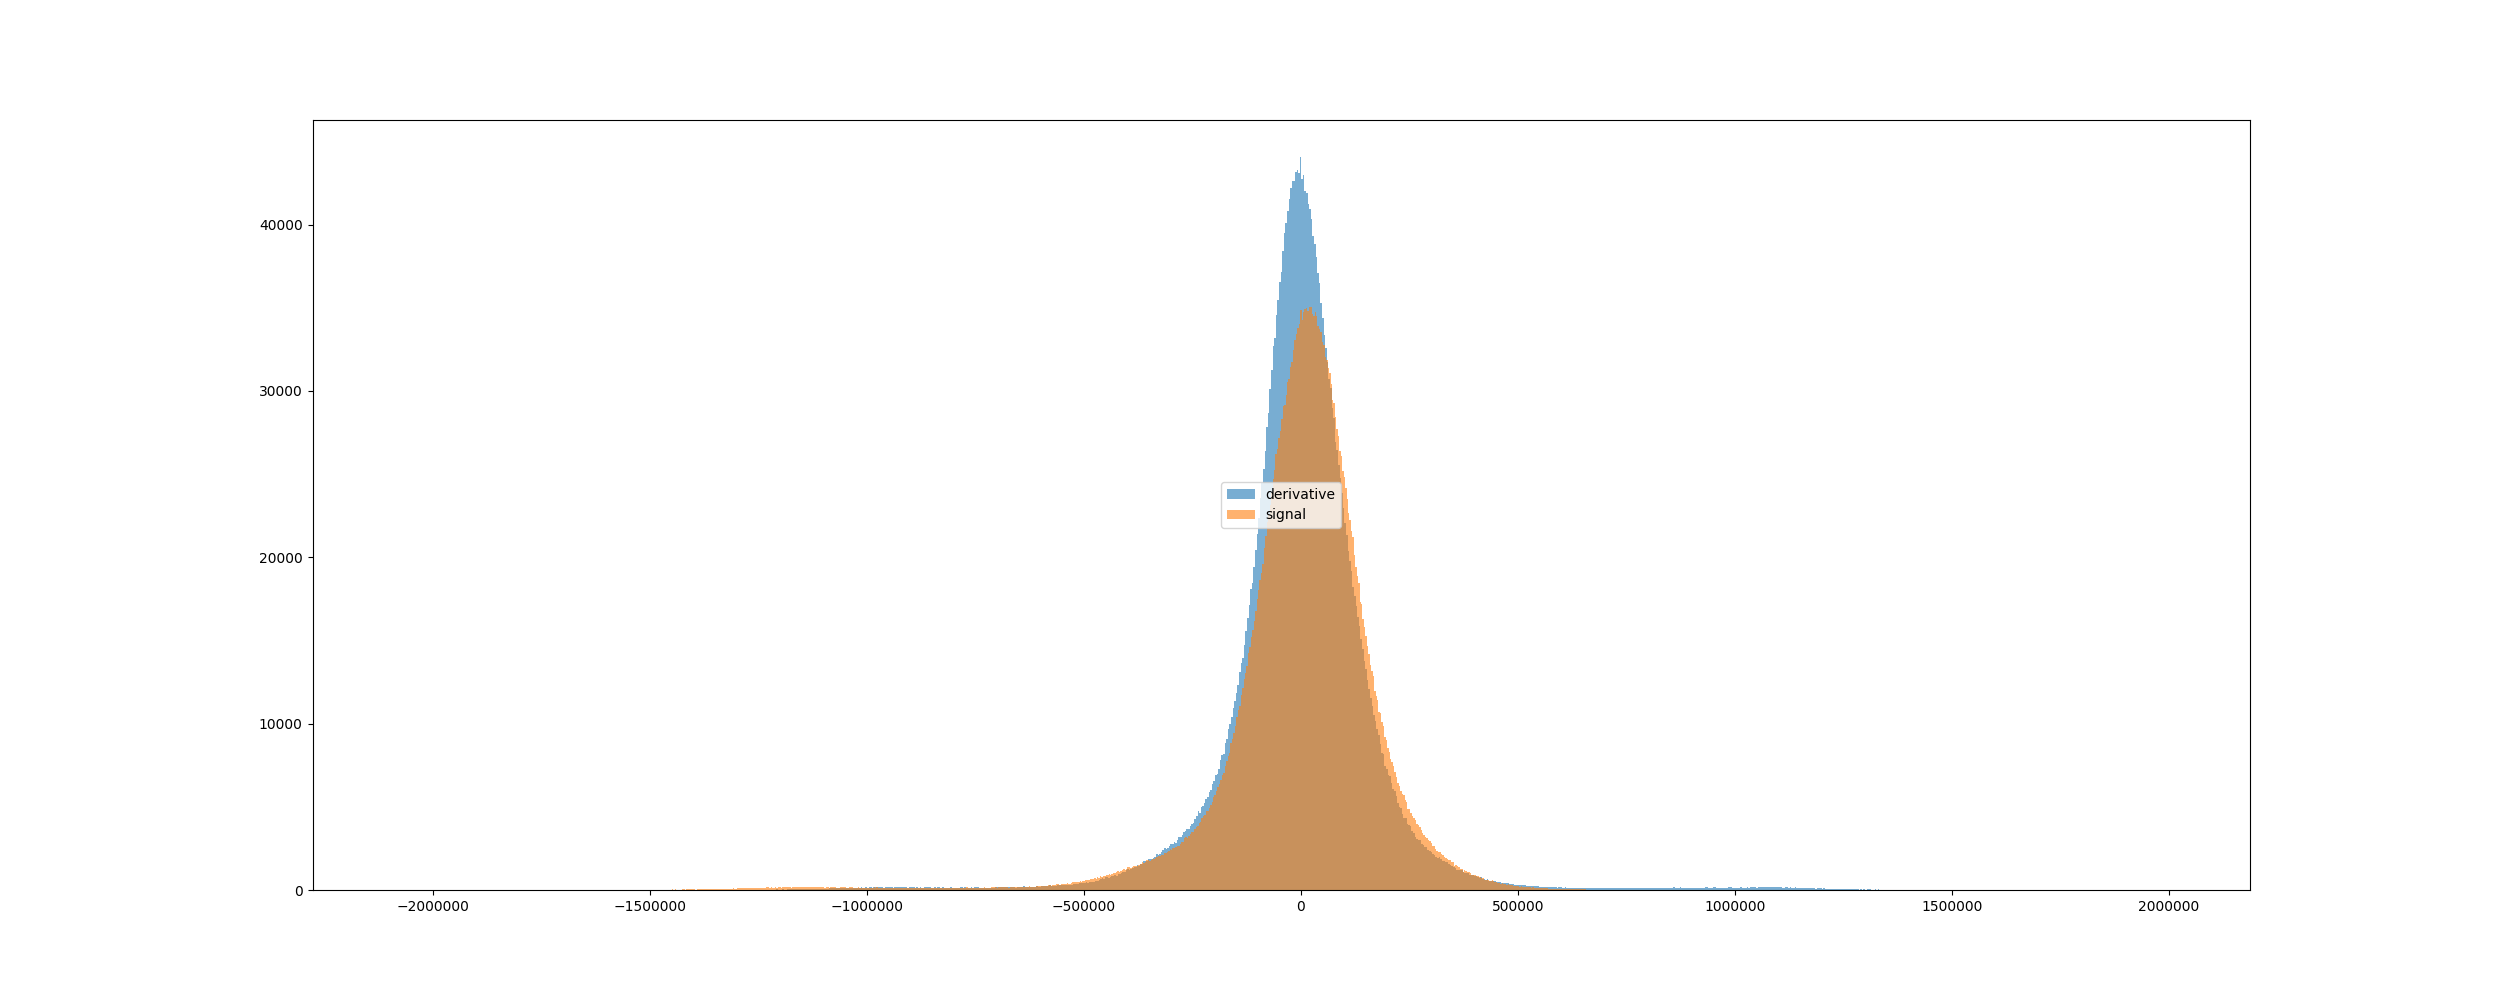

In [84]:
plt.figure(figsize=(25,10))
plt.hist(css.voltage_filtered[prange[0]:prange[1]],bins=1000 , alpha = 0.6)
plt.hist(css.voltage[prange[0]:prange[1]]*8000, bins=1000,alpha = 0.6)

plt.legend(['derivative', 'signal'], loc='center')

In [85]:
plt.savefig('../data/plots/tmp/deriv-voltage-histogram.png')

In [18]:
css.num_gmm_components = 5
css._detect_spikes_minibatch()

Using minibatch spike detection, batch size = 50s


In [64]:
spike_indices = css.get_spike_indices()

In [20]:
plt.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices<1008000, css.spike_indices>1000000))], linelengths=100000, lineoffsets=770000 , colors='r', zorder=10)
plt.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices<1008000, css.spike_indices>1000000))], linelengths=100000, lineoffsets=-970000 , colors='r', zorder=10)